In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import defaultdict

In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_val = pd.read_csv('/content/val.csv')
df_test = pd.read_csv('/content/test.csv')

In [ ]:
df_train

,Id,Text,Class
0,0,"Обустройство тротуаров, мостовых (в том числе ...",H
1,1,Въ издержкахъ же оныхъ вы имете присылать счет...,H
2,2,"Положи это туда, откуда взял.",H
3,3,Минстрой обозначил способы снижения энергоемко...,M
4,4,В конце 1873 года военный суд вынес решение по...,M
...,...,...,...
129061,215102,Убытки МУП &quot;Теплоэнерго&nbsp;&ndash;. На ...,M
129062,215104,Три сестры были молодёжными послами на Национа...,H
129063,215105,В Прекрасной России Будущего коты создадут сво...,H
129064,215106,В семье наше будущее!,M


In [ ]:
df_train.columns = ['id', 'input', 'target']
df_train = df_train[['input', 'target']]
df_train['target'].replace({'H': 1, 'M': 0}, inplace=True)
df_train.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,input,target
0,"Обустройство тротуаров, мостовых (в том числе ...",1
1,Въ издержкахъ же оныхъ вы имете присылать счет...,1
2,"Положи это туда, откуда взял.",1
3,Минстрой обозначил способы снижения энергоемко...,0
4,В конце 1873 года военный суд вынес решение по...,0


In [ ]:
df_val.columns = ['id', 'input', 'target']
df_val = df_val[['input', 'target']]
df_val['target'].replace({'H': 1, 'M': 0}, inplace=True)

df_test.columns = ['id', 'input']
df_test = df_test[['input']]

In [ ]:
df_train['target'].value_counts()

# Подготовка датасета

In [ ]:
!pip install transformers

In [ ]:
import torch 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 
from torch.optim import Adam
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch.nn.functional as F

In [ ]:
MODEL_PATH = "cointegrated/rubert-tiny"

In [ ]:
from transformers import AutoTokenizer, AutoModel
  
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

In [ ]:
max_len = 0 

for value in df_train['input'].values: 
    max_len = max(max_len, len(tokenizer.tokenize(value)))

max_len

# возьмем 512 в таком случае, что поделать(, пока так, потом, может быть, возьмем модели побольше

Token indices sequence length is longer than the specified maximum sequence length for this model (747 > 512). Running this sequence through the model will result in indexing errors


1137

In [ ]:
MAX_LEN = 512

In [ ]:
class SentencesDataset(Dataset): 
    def __init__(self, sentences, target, tokenizer, max_len): 
        self.sentences = sentences 
        self.target = target 
        self.tokenizer = tokenizer 
        self.max_len = max_len 

    def __len__(self): 
        return len(self.sentences)

    def __getitem__(self, idx): 
        sentence = self.sentences[idx]
        target = self.target[idx]

        encoding = tokenizer.encode_plus( 
            sentence, 
            add_special_tokens=True, 
            max_length=self.max_len, 
            padding='max_length', 
            truncation=True, 
            return_token_type_ids=False, 
            return_attention_mask=True, 
            return_tensors='pt'
        )

        return {
            'sentence': sentence, 
            'input_ids': encoding['input_ids'].flatten(), 
            'attention_mask': encoding['attention_mask'].flatten(), 
            'target': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
df_test.shape

(64533, 1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


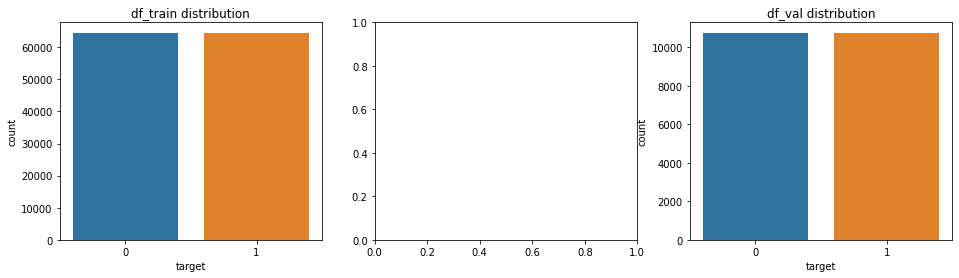

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
sns.countplot(df_train['target'], ax = ax1)
ax1.set_title('df_train distribution')

# sns.countplot(df_test['target'], ax = ax2)
# ax2.set_title('df_test distribution')

sns.countplot(df_val['target'], ax = ax3)
ax3.set_title('df_val distribution')

fig.show()

In [ ]:
def create_data_loader(df, tokenizer, batch_size, max_len): 
    data = SentencesDataset(
        sentences=df['input'].to_numpy(), 
        target=df['target'].to_numpy(), 
        tokenizer=tokenizer, 
        max_len = max_len 
    )

    return DataLoader (
        data, 
        batch_size=batch_size, 
        num_workers=2
    )

In [ ]:
BATCH_SIZE = 4
MAX_LEN = 512

train_data_loader = create_data_loader(df_train, tokenizer, BATCH_SIZE, MAX_LEN)
test_data_loader = create_data_loader(df_val, tokenizer, BATCH_SIZE, MAX_LEN)
val_data_loader = create_data_loader(df_val, tokenizer, BATCH_SIZE, MAX_LEN)

# Обучение

In [ ]:
class SentencesClassifier(nn.Module): 
    def __init__(self, n_classes): 
        super(SentencesClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(MODEL_PATH, return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask): 
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )

        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
clf = SentencesClassifier(n_classes=2)
clf = clf.to(device)

Downloading:   0%|          | 0.00/45.5M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
EPOCHS = 15

optimizer = Adam(clf.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss().to(device)
total_steps = len(train_data_loader) * EPOCHS 

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [ ]:
def train_epoch(
    model, 
    data_loader, 
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    n_examples
): 

    model = model.train() 

    losses = []
    correct_predictions = 0 

    for data in data_loader: 
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        target = data['target'].to(device)

        output = model(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )

        _, preds = torch.max(output, dim=1)
        loss = loss_fn(output, target)

        correct_predictions += torch.sum(preds == target)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(
    model, 
    data_loader, 
    loss_fn, 
    device, 
    n_examples
): 
    model = model.eval() 

    losses = [] 
    correct_predictions = 0

    with torch.no_grad(): 
        for data in data_loader: 
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            target = data['target'].to(device)

            output = model(
                input_ids=input_ids, 
                attention_mask=attention_mask
            )

            _, preds = torch.max(output, dim=1)
            loss = loss_fn(output, target)
            losses.append(loss.item())

            correct_predictions += torch.sum(preds == target)
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
history = defaultdict(list)

for epoch in range(EPOCHS): 
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 70)

    train_acc, train_loss = train_epoch(
        clf, 
        train_data_loader, 
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        df_train.shape[0]
    )

    print('Train loss = {}, Train acc = {}'.format(train_loss, train_acc))

    val_acc, val_loss = eval_model(
        clf, 
        val_data_loader, 
        loss_fn, 
        device, 
        df_val.shape[0]
    )

    print('Val loss = {}, Val acc = {}'.format(val_loss, val_acc), '\n')

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if epoch + 1 > 1: 
        torch.save(clf, './drive/MyDrive/prozhito_binary_clf/models_checkpoints/rubert_tiny_{}'.format(epoch + 1))

Epoch 1/15
----------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Train loss = 0.5401923771066601, Train acc = 0.7033920629755319
Val loss = 0.4887420904102942, Val acc = 0.7402259309190646 

Epoch 2/15
----------------------------------------------------------------------
Train loss = 0.4921767025946123, Train acc = 0.7619125098786667
Val loss = 0.521766674542089, Val acc = 0.7485937427362744 



FileNotFoundError: ignored

In [ ]:
def get_predictions(model, data_loader): 
    model = model.eval()

    sentences = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad(): 
        for data in data_loader: 
            texts = data['sentence']
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['target'].to(device)

            output = model(
                input_ids=input_ids, 
                attention_mask=attention_mask
            )

            _, preds = torch.max(output, dim=1)
            probs = F.softmax(output, dim=1)

            sentences.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return sentences, predictions, prediction_probs, real_values

In [ ]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
  clf,
  test_data_loader
)

In [ ]:
'Accuracy = {:.2f}'.format(test_acc.item())

'Accuracy = 0.86'